## Imports

In [1]:
import lenstronomy

lenstronomy.__version__

'1.9.3'

In [2]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import gc
from tqdm import tnrange

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Util import mask_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import paperfig as pf

pf.set_fontscale(2.)

import sys
sys.path.insert(0, './process_output')

from output_class import *
# to load the custom_log_likelihood function for unpickling

savefig = False

# Load output files

In [4]:
composite_files = [
    '2038_run205_1_0_0_0_0_shortened',
    '2038_run205_1_0_1_0_0_shortened',
    '2038_run205_1_0_2_0_0_shortened',
    '2038_run205_1_1_0_0_0_shortened',
    '2038_run205_1_1_1_0_0_shortened',
    '2038_run205_1_1_2_0_0_shortened',
    
    '2038_run206_1_0_0_0_0_shortened',
    '2038_run206_1_0_1_0_0_shortened',
    '2038_run206_1_0_2_0_0_shortened',
    '2038_run206_1_1_0_0_0_shortened',
    '2038_run206_1_1_1_0_0_shortened',
    '2038_run206_1_1_2_0_0_shortened',
    
#     '2038_run178_1_0_0_0_0_shortened',
#     '2038_run178_1_0_1_0_0_shortened',
#     '2038_run178_1_0_2_0_0_shortened',
#     '2038_run178_1_1_0_0_0_shortened',
#     '2038_run178_1_1_1_0_0_shortened',
#     '2038_run178_1_1_2_0_0_shortened',
    
#     '2038_run179_1_0_0_0_0_shortened',
#     '2038_run179_1_0_1_0_0_shortened',
#     '2038_run179_1_0_2_0_0_shortened',
#     '2038_run179_1_1_0_0_0_shortened',
#     '2038_run179_1_1_1_0_0_shortened',
#     '2038_run179_1_1_2_0_0_shortened',
]

In [5]:
composite_bics = []
composite_param_arrays = []
composite_num_param_arrays = []
composite_kwargs_models = []
composite_kwargs_constraints = []
composite_param_classes = []
composite_lens_models = []
composite_kwargs_likelihoods = []
composite_multi_band_list = []

for job_name_out in composite_files:
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    fitting_kwargs_list, kwargs_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
    kwargs_result, multi_band_list_out, fit_output, _ = output_
    multi_band_list = kwargs_joint['multi_band_list']

    samples_mcmc = fit_output[-1][1][np.random.randint(0, high=fit_output[-1][1].shape[0], size=10000)]
    param_mcmc = fit_output[-1][2]
    
    param_class = Param(kwargs_model,
                        kwargs_params['lens_model'][2], 
                        kwargs_params['source_model'][2],
                        kwargs_params['lens_light_model'][2],
                        kwargs_params['point_source_model'][2],
                        kwargs_lens_init=kwargs_params['lens_model'][0], #kwargs_result['kwargs_lens'],
                        **kwargs_constraints
                       )
    
    lens_model = LensModel(lens_model_list=kwargs_model['lens_model_list'],
                           z_lens=0.230, z_source=0.777,
                           multi_plane=False, #True, 
                          )
    
    num_data = np.sum([np.sum(m) for m in kwargs_likelihood['image_likelihood_mask_list']])
    num_param = param_class.num_param()[0] + param_class.num_param_linear()
    max_logL = np.max(fit_output[-1][-1])
    
    bic = compute_BIC(num_data, num_param, max_logL)
    
    composite_bics.append(bic)
    composite_param_arrays.append(np.copy(samples_mcmc))
    composite_num_param_arrays.append(len(samples_mcmc))
    composite_kwargs_models.append(kwargs_model)
    composite_kwargs_constraints.append(kwargs_constraints)
    composite_param_classes.append(param_class)
    composite_lens_models.append(lens_model)
    composite_kwargs_likelihoods.append(kwargs_likelihood)
    composite_multi_band_list.append(multi_band_list_out)
    
    gc.collect()
    #break

## Compute BIC weights and combine models

In [6]:
len(composite_kwargs_models)

12

In [7]:
# from the notebook "Fermat potentials and lens model comparisons"
sigma_numeric_bic, sigma_model_bic = 69.05339424569138, 237.25336211795366

In [8]:
num_sample = 100

In [9]:
composite_vel_dis_profiles = []
a_anis = []
r_effs = []

a_ani_min = 0.5
a_ani_max = 5

rs = np.arange(0., 1.51, 0.1)

kwargs_galkin_numerics = {#'sampling_number': 1000,
                                       'interpol_grid_num': 1000,
                                       'log_integration': True,
                                       'max_integrate': 100,
                                       'min_integrate': 0.001}

lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)

composite_weights = get_relative_weights(composite_bics, sigma_model_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)    

for n_job in tnrange(len(composite_files), desc='Jobs:'):
    
    r200s, M200s, c200s = [], [], []
    stellar_mass = []
    total_mass_within_0p2_arcsec = []
    
    num_sample_from_job = int(num_sample * composite_weights[n_job])
    
    sampled_indices = np.random.randint(low=0, high=composite_num_param_arrays[n_job], size=num_sample_from_job)
    
    lens_model = composite_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(composite_lens_models[n_job])
    
    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
        param_array = composite_param_arrays[n_job][sampled_indices[i]]

        param_class = composite_param_classes[n_job]
        
        kwargs_result = param_class.args2kwargs(param_array)
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']

        #_, _, c, r, M = lens_cosmo.nfw_angle2physical(lens_result[0]['Rs'], lens_result[0]['alpha_Rs'])
        
        #num_samples = self.get_num_samples()

        model_velocity_dispersion = []

        anisotropy_model = 'isotropic'  # anisotropy model applied
        aperture_type = 'IFU_shells'  # type of aperture used

        #if num_compute is None:
        #    num_compute = num_samples - start_index

        n = 0

        # source_result = kwargs_result['kwargs_source']
        # ps_result = kwargs_result['kwargs_ps']

        if False: #self.is_test:
            band_index = 0
        else:
            band_index = 2

        kwargs_aperture = {'aperture_type': aperture_type,
                           #'length': self.APERTURE_LENGTH[n],
                           #'width': self.SLIT_WIDTH[n],
                           'center_ra': 0., #lens_light_result[0]['center_x'],
                           'center_dec': 0., #lens_light_result[0]['center_y'],
                           #'angle': 0
                            'r_bins': rs
                           }

        kwargs_seeing = {'psf_type': 'GAUSSIAN',
                         'fwhm': 0.001, #self.PSF_FWHM[n],
                         #'moffat_beta': self.MOFFAT_BETA[n]
                        }

#         light_model_bool = [False] * len(
#             kwargs_model['lens_light_model_list'])

#         if False:
#             light_model_bool[0] = True
#         else:
#             if False: #self.model_type == "powerlaw":
#                 # indices: 8, 9, 10
#                 light_model_bool[6] = True  # F160W Sersic profile
#                 light_model_bool[7] = True
#                 light_model_bool[8] = True
#             elif True: #self.model_type == "composite":
#                 light_model_bool[6] = True  # Chameleon profile F160W index: 6
#             else:
#                 raise NotImplementedError

        kwargs_model['lens_light_model_list'] = ['MULTI_GAUSSIAN',
                                                      'MULTI_GAUSSIAN',
                                                      'MULTI_GAUSSIAN']
                                                                            
        light_model_bool = [False, False, True]

        lens_model_bool = [False] * len(
            kwargs_model['lens_model_list'])

        if False: #self.model_type == 'powerlaw':  # self.kwargs_model['lens_model_list'][0] == 'SPEMD':
            lens_model_bool[0] = True

            cGD_light = False
            cGD_mass = False
        else:
            lens_model_bool[0] = True
            lens_model_bool[2] = True

            cGD_light = False
            cGD_mass = True

        kinematics_api = KinematicsAPI(z_lens=0.23, 
                                       z_source=0.777,
                                       kwargs_model=kwargs_model,
                                       kwargs_aperture=kwargs_aperture,
                                       kwargs_seeing=kwargs_seeing,
                                       anisotropy_model=anisotropy_model,
                                       cosmo=None,
                                       lens_model_kinematics_bool=lens_model_bool,
                                       light_model_kinematics_bool=light_model_bool,
                                       multi_observations=False,
                                       kwargs_numerics_galkin=kwargs_galkin_numerics,
                                       analytic_kinematics=False,
                                       Hernquist_approx=False,
                                       MGE_light=cGD_light,
                                       MGE_mass=cGD_mass,
                                       kwargs_mge_light=None,
                                       kwargs_mge_mass=None,
                                       sampling_number=1000,
                                       num_kin_sampling=2000,
                                       num_psf_sampling=500)

        for i in range(1): # start_index, start_index+num_compute):
#             if print_step is not None:
#                 if (i-start_index)%print_step == 0:
#                     print('Computing step: {}'.format(i-start_index))

#             sample = self.samples_mcmc[i]

            #vel_dis_array = []

            r_eff_uncertainty_factor = np.random.normal(loc=1., scale=0.03)

            if False: #self.is_test:
                a_ani = 2
            else:
                r_eff = 2.4 * r_eff_uncertainty_factor #self.get_r_eff(i)
    
                     # Jeffrey's prior for a_ani
                a_ani = 10**np.random.uniform(np.log10(a_ani_min),
                                              np.log10(a_ani_max))

            a_anis.append(a_ani)
            r_effs.append(r_eff)

            #kwargs_result = self.param_class.args2kwargs(sample)

            # set the anisotropy radius. r_eff is pre-computed half-light
            # radius of the lens light
            kwargs_anisotropy = {} #'r_ani': a_ani * r_eff}

            kwargs_gaussian_light = [{
                'center_x': lens_light_result[0]['center_x'],
                'center_y': lens_light_result[0]['center_y'],
                # these values are from the isophote model -> MGE fit in F814W
                'amp': np.array([28.8552871 , 136.50077782, 165.79432709, 326.27644665,
        471.53423998, 809.66654098]),
                'sigma': np. array([0.08652982, 0.25408345, 0.51528969, 0.68861029, 1.86218783,
        2.67014751]) * r_eff_uncertainty_factor
            }] * 3

            # compute the velocity disperson in a pre-specified cosmology
            # (see lenstronomy function)
            vel_dis = kinematics_api.velocity_dispersion_map(
                kwargs_result['kwargs_lens'],
                kwargs_gaussian_light,
                #kwargs_result['kwargs_lens_light'],
                kwargs_anisotropy
            )
    
            #print(vel_dis)
            composite_vel_dis_profiles.append(vel_dis)

        
        

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Sample from job 0::   0%|          | 0/36 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/ajshajib/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Sample from job 1::   0%|          | 0/63 [00:00<?, ?it/s]


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


Sample from job 2::   0%|          | 0/100 [00:00<?, ?it/s]


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


Sample from job 3:: 0it [00:00, ?it/s]

Sample from job 4:: 0it [00:00, ?it/s]

Sample from job 5:: 0it [00:00, ?it/s]

Sample from job 6::   0%|          | 0/31 [00:00<?, ?it/s]


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


Sample from job 7::   0%|          | 0/50 [00:00<?, ?it/s]

Sample from job 8::   0%|          | 0/98 [00:00<?, ?it/s]


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


Sample from job 9:: 0it [00:00, ?it/s]

Sample from job 10:: 0it [00:00, ?it/s]

Sample from job 11:: 0it [00:00, ?it/s]

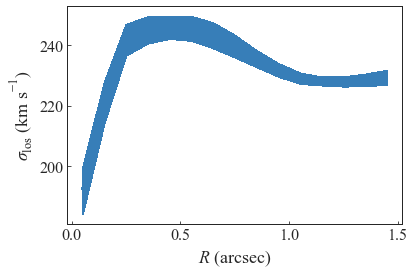

In [12]:
vel_dis_upper_quantile, vel_dis_med_quantile, vel_dis_lower_quantile  = np.percentile(composite_vel_dis_profiles, q=[84, 50, 16], axis=0)

_rs = np.arange(0.05, 1.5, 0.1)

fig = plt.figure()
ax = fig.add_subplot(111)

for v in composite_vel_dis_profiles:
    ax.plot(_rs, vel_dis_med_quantile, c=pf.cb_blue)
    ax.fill_between(_rs, vel_dis_upper_quantile, vel_dis_lower_quantile, alpha=0.4, color=pf.cb_blue)
    ax.set_xlabel(r'$R$ (arcsec)')
    
    ax.set_ylabel(r'$\sigma_{\rm los}$ (km s$^{-1}$)')

### powerlaw profiles

In [13]:
powerlaw_files = [
    '2038_run145_0_0_0_0_0_shortened',
    '2038_run145_0_0_1_0_0_shortened',
    '2038_run145_0_0_2_0_0_shortened',
    '2038_run145_0_1_0_0_0_shortened',
    '2038_run145_0_1_1_0_0_shortened',
    '2038_run145_0_1_2_0_0_shortened',
    
    '2038_run146_0_0_0_0_0_shortened',
    '2038_run146_0_0_1_0_0_shortened',
    '2038_run146_0_0_2_0_0_shortened',
    '2038_run146_0_1_0_0_0_shortened',
    '2038_run146_0_1_1_0_0_shortened',
    '2038_run146_0_1_2_0_0_shortened',
]

In [14]:
powerlaw_bics = []
powerlaw_param_arrays = []
powerlaw_num_param_arrays = []
powerlaw_kwargs_models = []
powerlaw_kwargs_constraints = []
powerlaw_param_classes = []
powerlaw_lens_models = []
powerlaw_kwargs_likelihoods = []
powerlaw_multi_band_list = []
powerlaw_kwargs_joint = []

for job_name_out in powerlaw_files:
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    fitting_kwargs_list, kwargs_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
  
    kwargs_result, multi_band_list_out, fit_output, _ = output_
    multi_band_list = kwargs_joint['multi_band_list']

    samples_mcmc = fit_output[-1][1] #[np.random.randint(0, high=fit_output[-1][1].shape[0], size=N_sample)]
    param_mcmc = fit_output[-1][2]
    
    param_class = Param(kwargs_model,
                        kwargs_params['lens_model'][2], 
                        kwargs_params['source_model'][2],
                        kwargs_params['lens_light_model'][2],
                        kwargs_params['point_source_model'][2],
                        kwargs_lens_init=kwargs_params['lens_model'][0], #kwargs_result['kwargs_lens'],
                        **kwargs_constraints
                       )
    
    lens_model = LensModel(lens_model_list=kwargs_model['lens_model_list'],
                           z_lens=0.230, z_source=0.777,
                           multi_plane=False, #True, 
                          )
    
    num_data = np.sum([np.sum(m) for m in kwargs_likelihood['image_likelihood_mask_list']])
    num_param = param_class.num_param()[0] + param_class.num_param_linear()
    max_logL = np.max(fit_output[-1][-1])
    
    bic = compute_BIC(num_data, num_param, max_logL)
    
    powerlaw_bics.append(bic)
    powerlaw_param_arrays.append(np.copy(samples_mcmc))
    powerlaw_num_param_arrays.append(len(samples_mcmc))
    powerlaw_kwargs_models.append(kwargs_model)
    powerlaw_kwargs_constraints.append(kwargs_constraints)
    powerlaw_param_classes.append(param_class)
    powerlaw_lens_models.append(lens_model)
    powerlaw_kwargs_likelihoods.append(kwargs_likelihood)
    powerlaw_multi_band_list.append(multi_band_list_out)
    powerlaw_kwargs_joint.append(kwargs_joint)
    
    gc.collect()
    #break

In [15]:
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.class_creator as class_creator


pl_vel_dis_profiles = []

lens_cosmo = LensCosmo(z_lens=0.230, z_source=0.777)

powerlaw_weights = get_relative_weights(powerlaw_bics, sigma_model_bic, take_std=False, 
                                  sigma_model=sigma_model_bic)    

powerlaw_profiles = []
sersic_profiles = []


for n_job in tnrange(len(composite_files), desc='Jobs:'):
    num_sample_from_job = int(num_sample * powerlaw_weights[n_job])
    
    sampled_indices = np.random.randint(low=0, high=powerlaw_num_param_arrays[n_job], size=num_sample_from_job)
    
    lens_model = powerlaw_lens_models[n_job] #lens_analysis.LensModel
    lens_analysis = LensProfileAnalysis(powerlaw_lens_models[n_job])

    lens_profile = LensProfileAnalysis(lens_model)
    
    kwargs_model = powerlaw_kwargs_models[n_job]
    
    light_model = LightModel(kwargs_model['lens_light_model_list'])
    light_analysis = LightProfileAnalysis(light_model)
    
    
    for i in tnrange(len(sampled_indices), desc='Sample from job {:d}:'.format(n_job)): #len(samples_mcmc)):
        r = np.logspace(-2, 1, 100)
        
        param_array = powerlaw_param_arrays[n_job][sampled_indices[i]]

        param_class = powerlaw_param_classes[n_job]
        
        kwargs_result = param_class.args2kwargs(param_array)
        lens_result = kwargs_result['kwargs_lens']
        lens_light_result = kwargs_result['kwargs_lens_light']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']

        #_, _, c, r, M = lens_cosmo.nfw_angle2physical(lens_result[0]['Rs'], lens_result[0]['alpha_Rs'])
        
        #num_samples = self.get_num_samples()

        model_velocity_dispersion = []

        anisotropy_model = 'isotropic'  # anisotropy model applied
        aperture_type = 'IFU_shells'  # type of aperture used

        #if num_compute is None:
        #    num_compute = num_samples - start_index

        n = 0

        # source_result = kwargs_result['kwargs_source']
        # ps_result = kwargs_result['kwargs_ps']

        if False: #self.is_test:
            band_index = 0
        else:
            band_index = 2

        kwargs_aperture = {'aperture_type': aperture_type,
                           #'length': self.APERTURE_LENGTH[n],
                           #'width': self.SLIT_WIDTH[n],
                           'center_ra': 0., #lens_light_result[0]['center_x'],
                           'center_dec': 0., #lens_light_result[0]['center_y'],
                           #'angle': 0
                            'r_bins': rs
                           }

        kwargs_seeing = {'psf_type': 'GAUSSIAN',
                         'fwhm': 0.001, #self.PSF_FWHM[n],
                         #'moffat_beta': self.MOFFAT_BETA[n]
                        }

#         light_model_bool = [False] * len(
#             kwargs_model['lens_light_model_list'])

#         if False:
#             light_model_bool[0] = True
#         else:
#             if False: #self.model_type == "powerlaw":
#                 # indices: 8, 9, 10
#                 light_model_bool[6] = True  # F160W Sersic profile
#                 light_model_bool[7] = True
#                 light_model_bool[8] = True
#             elif True: #self.model_type == "composite":
#                 light_model_bool[6] = True  # Chameleon profile F160W index: 6
#             else:
#                 raise NotImplementedError

        kwargs_model['lens_light_model_list'] = ['MULTI_GAUSSIAN',
                                                      'MULTI_GAUSSIAN',
                                                      'MULTI_GAUSSIAN']
                                                                            
        light_model_bool = [False, False, True]

        lens_model_bool = [False] * len(
            kwargs_model['lens_model_list'])

        if True: #self.model_type == 'powerlaw':  # self.kwargs_model['lens_model_list'][0] == 'SPEMD':
            lens_model_bool[0] = True

            cGD_light = False
            cGD_mass = False
        else:
            lens_model_bool[0] = True
            lens_model_bool[2] = True

            cGD_light = False
            cGD_mass = True

        kinematics_api = KinematicsAPI(z_lens=0.23, 
                                       z_source=0.777,
                                       kwargs_model=kwargs_model,
                                       kwargs_aperture=kwargs_aperture,
                                       kwargs_seeing=kwargs_seeing,
                                       anisotropy_model=anisotropy_model,
                                       cosmo=None,
                                       lens_model_kinematics_bool=lens_model_bool,
                                       light_model_kinematics_bool=light_model_bool,
                                       multi_observations=False,
                                       kwargs_numerics_galkin=kwargs_galkin_numerics,
                                       analytic_kinematics=False,
                                       Hernquist_approx=False,
                                       MGE_light=cGD_light,
                                       MGE_mass=cGD_mass,
                                       kwargs_mge_light=None,
                                       kwargs_mge_mass=None,
                                       sampling_number=1000,
                                       num_kin_sampling=2000,
                                       num_psf_sampling=500)

        for i in range(1): # start_index, start_index+num_compute):
#             if print_step is not None:
#                 if (i-start_index)%print_step == 0:
#                     print('Computing step: {}'.format(i-start_index))

#             sample = self.samples_mcmc[i]

            #vel_dis_array = []

            r_eff_uncertainty_factor = np.random.normal(loc=1., scale=0.03)

            if False: #self.is_test:
                a_ani = 2
            else:
                r_eff = 2.4 * r_eff_uncertainty_factor #self.get_r_eff(i)
    
                     # Jeffrey's prior for a_ani
                a_ani = 10**np.random.uniform(np.log10(a_ani_min),
                                              np.log10(a_ani_max))

            a_anis.append(a_ani)
            r_effs.append(r_eff)

            #kwargs_result = self.param_class.args2kwargs(sample)

            # set the anisotropy radius. r_eff is pre-computed half-light
            # radius of the lens light
            kwargs_anisotropy = {} #'r_ani': a_ani * r_eff}

            kwargs_gaussian_light = [{
                'center_x': lens_light_result[0]['center_x'],
                'center_y': lens_light_result[0]['center_y'],
                # these values are from the isophote model -> MGE fit in F814W
                'amp': np.array([28.8552871 , 136.50077782, 165.79432709, 326.27644665,
        471.53423998, 809.66654098]),
                'sigma': np. array([0.08652982, 0.25408345, 0.51528969, 0.68861029, 1.86218783,
        2.67014751]) * r_eff_uncertainty_factor
            }] * 3

            # compute the velocity disperson in a pre-specified cosmology
            # (see lenstronomy function)
            vel_dis = kinematics_api.velocity_dispersion_map(
                kwargs_result['kwargs_lens'],
                kwargs_gaussian_light,
                #kwargs_result['kwargs_lens_light'],
                kwargs_anisotropy
            )
    
            #print(vel_dis)
            pl_vel_dis_profiles.append(vel_dis)

        
        

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Jobs::   0%|          | 0/12 [00:00<?, ?it/s]

/Users/ajshajib/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Sample from job 0::   0%|          | 0/27 [00:00<?, ?it/s]

Sample from job 1::   0%|          | 0/72 [00:00<?, ?it/s]

Sample from job 2::   0%|          | 0/94 [00:00<?, ?it/s]

Sample from job 3:: 0it [00:00, ?it/s]

Sample from job 4:: 0it [00:00, ?it/s]

Sample from job 5:: 0it [00:00, ?it/s]

Sample from job 6::   0%|          | 0/36 [00:00<?, ?it/s]

Sample from job 7::   0%|          | 0/75 [00:00<?, ?it/s]

Sample from job 8::   0%|          | 0/100 [00:00<?, ?it/s]

Sample from job 9:: 0it [00:00, ?it/s]

Sample from job 10:: 0it [00:00, ?it/s]

Sample from job 11:: 0it [00:00, ?it/s]

In [16]:
composite_vel_dis_upper_quantile, composite_vel_dis_med_quantile, composite_vel_dis_lower_quantile  = np.percentile(composite_vel_dis_profiles, q=[84, 50, 16], axis=0)
powerlaw_vel_dis_upper_quantile, powerlaw_vel_dis_med_quantile, powerlaw_vel_dis_lower_quantile  = np.percentile(pl_vel_dis_profiles, q=[84, 50, 16], axis=0)

_rs = np.arange(0.05, 1.5, 0.1)

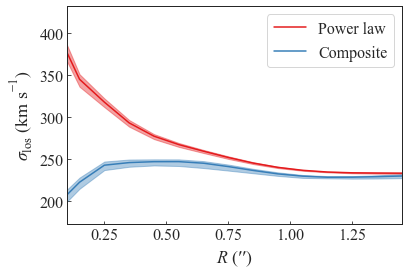

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)


ax.plot(_rs, powerlaw_vel_dis_med_quantile, c=pf.cb_red, label='Power law')
ax.plot(_rs, composite_vel_dis_med_quantile, c=pf.cb_blue, label='Composite')

ax.fill_between(_rs, powerlaw_vel_dis_upper_quantile, powerlaw_vel_dis_lower_quantile, alpha=0.4, color=pf.cb_red)
ax.fill_between(_rs, composite_vel_dis_upper_quantile, composite_vel_dis_lower_quantile, alpha=0.4, color=pf.cb_blue)
ax.set_xlabel(r'$R$ (${\prime\prime}$)')
ax.set_xlim(0.1, 1.45)
ax.legend()
ax.set_ylabel(r'$\sigma_{\rm los}$ (km s$^{-1}$)')

fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/velocity_dispersion_profile_lenstronomy.pdf',
            bbox_inches='tight')